### Import necessary packages
- os: get paths of files
- re: match something
- time: compute running time
- joblib: storage of MinMaxScalers and clfs
- numpy & pandas: data processing
- seaborn & matplotlib: plot figures
- sklearn: ANOVA

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

In [2]:
data_path = os.path.join(os.path.abspath('.'), 'datas')
feature_path = os.path.join(data_path, 'feature')
ifs_path = os.path.join(data_path, 'ifs')
bin_path = os.path.join(data_path, 'bin')
best_fea_appro = 'PD'
best_d = 193

In [3]:
# colors = ['sienna', 'crimson', 'yellowgreen', 'royalblue']
# colors = ['#FF5300','#FFB600', '#C9007A','#00AB6F']
# colors = ['#00B060','#4E00AE','#1144AA','#FFA700']
# colors = ['#FF6700','#FFB700','#DE0052','#00A287']
# colors = ['#515bd4', '#8134af', '#dd2a7b', '#FF6700']
# about equal to upper one
# colors = ['#3A0088','#930077','#E61C5D','#FFBD39']
# colors = ['#F8B43D','#F87E3D','#28A47F','#345FA4']
# about equal to upper one
# colors = ['#F8AD3D', '#F8703D','#2AAB70','#3168A1']
# colors = ['#FFbb00','#ff6c00','#df004f','#009e8e']
# plain colors
# colors = ['#67D5B5', '#EE7785', '#C89EC4', '#84B1ED']
colors = ['#00C770', '#F04271', '#8767C7', '#3094DB']
opts = ['grid', 'bayes']
labels = [
    'PseCKSAAP',
    'PseCKSAAP+DDE',
    'PseCKSAAP+DDE+CTD',
    'PseCKSAAP+DDE+CTD+QSOrder',
]

## Plot ROCs

In [4]:
test_roc_grid = pd.read_csv(
    os.path.join(data_path, 'base_grid_test_roc.csv'), index_col=0
)
test_roc_bayes = pd.read_csv(
    os.path.join(data_path, 'base_bayes_test_roc.csv'), index_col=0
)
test_result_grid = pd.read_csv(
    os.path.join(data_path, 'base_grid_test_results.csv')
)
test_result_bayes = pd.read_csv(
    os.path.join(data_path, 'base_bayes_test_results.csv')
)

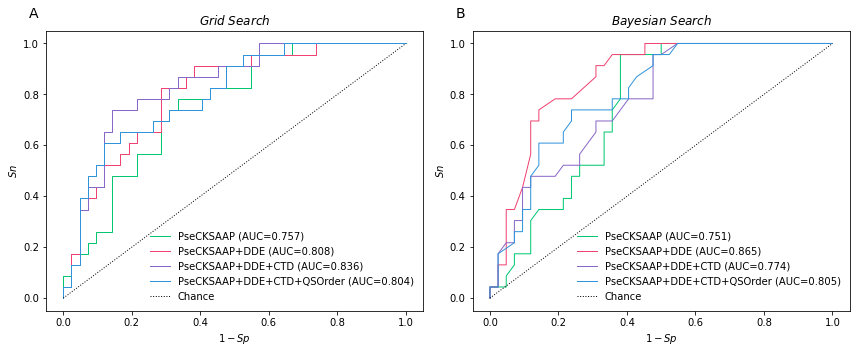

In [5]:
fig1 = plt.figure(1, figsize=(12, 5))
for opt in opts:
    if opt == 'grid':
        ax_test_roc = fig1.add_subplot(121)
        for name, color, label, auc in zip(
            test_roc_grid.columns,
            colors,
            labels,
            test_result_grid.loc[:, 'AUC'],
        ):
            ax_test_roc.plot(
                eval(test_roc_grid.loc['fpr', name]),
                eval(test_roc_grid.loc['tpr', name]),
                label=label + ' (AUC=%.3f)' % auc,
                color=color,
                linewidth=1,
            )
    else:
        ax_test_roc = fig1.add_subplot(122)
        for name, color, label, auc in zip(
            test_roc_bayes.columns,
            colors,
            labels,
            test_result_bayes.loc[:, 'AUC'],
        ):
            ax_test_roc.plot(
                eval(test_roc_bayes.loc['fpr', name]),
                eval(test_roc_bayes.loc['tpr', name]),
                label=label + ' (AUC=%.3f)' % auc,
                color=color,
                linewidth=1,
            )
    ax_test_roc.plot(
        [0, 1], [0, 1], label='Chance', linestyle=':', color='k', linewidth=1,
    )
    ax_test_roc.legend(frameon=False, loc='lower right')
    if opt == 'grid':
        ax_test_roc.set(
            title=r'$\it{Grid}$ $\it{Search}$',
            xlabel=r'$1 - \it{Sp}$',
            ylabel=r'$\it{Sn}$',
        )
        ax_test_roc.text(-0.1, 1.1, 'A', fontsize=14)
    else:
        ax_test_roc.set(
            title=r'$\it{Bayesian}$ $\it{Search}$',
            xlabel=r'$1 - \it{Sp}$',
            ylabel=r'$\it{Sn}$',
        )
        ax_test_roc.text(-0.1, 1.1, 'B', fontsize=14)

fig1.tight_layout()
plt.savefig(os.path.join(data_path, 'test_rocs.jpg'), dpi=600)

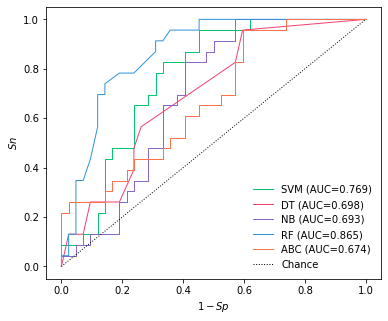

In [6]:
clf_roc = pd.read_csv(
    os.path.join(data_path, 'clfs_test_roc.csv'), index_col=0
)
clf_roc.insert(3, 'RF', test_roc_bayes['PD'].tolist() + [None])

clf_result = pd.read_csv(
    os.path.join(data_path, 'clfs_bayes_test_results.csv')
)
clf_result = pd.DataFrame(
    np.insert(
        clf_result.values,
        3,
        values=['RF'] + test_result_bayes.iloc[1, 1:].tolist(),
        axis=0,
    ),
    columns=clf_result.columns,
)

fig1_clf = plt.figure(2, figsize=(6, 5))
ax_clf_roc = fig1_clf.subplots()
for clf, color, auc in zip(  # '#FFB4A2'
    clf_roc.columns, colors + ['#FF714B'], clf_result.loc[:, 'AUC']
):
    ax_clf_roc.plot(
        eval(clf_roc.loc['fpr', clf]),
        eval(clf_roc.loc['tpr', clf]),
        label=clf + ' (AUC=%.3f)' % auc,
        color=color,
        linewidth=1,
    )
ax_clf_roc.plot(
    [0, 1], [0, 1], label='Chance', linestyle=':', color='k', linewidth=1,
)
ax_clf_roc.legend(frameon=False, loc='lower right')
ax_clf_roc.set(
    xlabel=r'$1 - \it{Sp}$', ylabel=r'$\it{Sn}$',
)
plt.savefig(os.path.join(data_path, 'clfs_rocs.jpg'), dpi=600)

## plot IFS curves

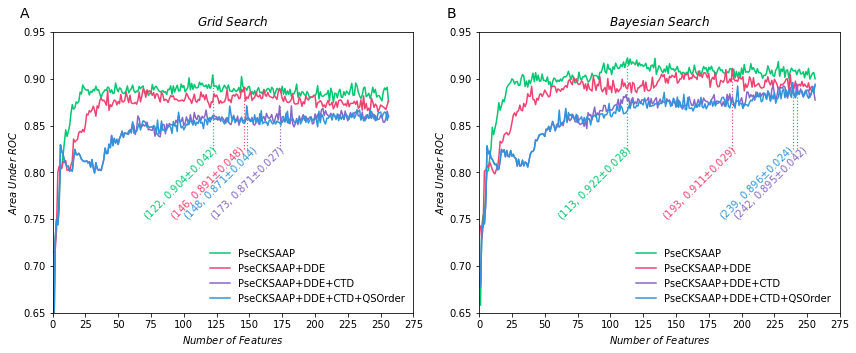

In [7]:
fig2 = plt.figure(3, figsize=(12, 5))
for opt in opts:
    ifs_P = pd.read_csv(
        os.path.join(ifs_path, 'base_' + opt + '_ifs_P.csv'),
        # 0: d, 1: auc_mean, 2: auc_std, 3: estimator
        usecols=[0, 1, 2],
    )
    ifs_PD = pd.read_csv(
        os.path.join(ifs_path, 'base_' + opt + '_ifs_PD.csv'),
        usecols=[0, 1, 2],
    )
    ifs_PDC = pd.read_csv(
        os.path.join(ifs_path, 'base_' + opt + '_ifs_PDC.csv'),
        usecols=[0, 1, 2],
    )
    ifs_PDCQ = pd.read_csv(
        os.path.join(ifs_path, 'base_' + opt + '_ifs_PDCQ.csv'),
        usecols=[0, 1, 2],
    )

    # 1.auc score ↑; 2. dimension ↓
    d1, score1, std1 = (
        ifs_P.sort_values(
            by=['auc_mean', 'dimension'], ascending=[True, False],
        )
        .dropna()
        .iloc[-1, :]
    )
    d1 = int(d1)
    d2, score2, std2 = (
        ifs_PD.sort_values(
            by=['auc_mean', 'dimension'], ascending=[True, False]
        )
        .dropna()
        .iloc[-1, :]
    )
    d2 = int(d2)
    d3, score3, std3 = (
        ifs_PDC.sort_values(
            by=['auc_mean', 'dimension'], ascending=[True, False]
        )
        .dropna()
        .iloc[-1, :]
    )
    d3 = int(d3)
    d4, score4, std4 = (
        ifs_PDCQ.sort_values(
            by=['auc_mean', 'dimension'], ascending=[True, False]
        )
        .dropna()
        .iloc[-1, :]
    )
    d4 = int(d4)
    if opt == 'grid':
        ax_ifs = fig2.add_subplot(121)
    else:
        ax_ifs = fig2.add_subplot(122)
    ax_ifs.plot(
        np.arange(1, len(ifs_P) + 1),
        ifs_P.iloc[:, 1],
        label=labels[0],
        color=colors[0],
    )
    ax_ifs.plot(
        np.arange(1, len(ifs_PD) + 1),
        ifs_PD.iloc[:, 1],
        label=labels[1],
        color=colors[1],
    )
    ax_ifs.plot(
        np.arange(1, len(ifs_PDC) + 1),
        ifs_PDC.iloc[:, 1],
        label=labels[2],
        color=colors[2],
    )
    ax_ifs.plot(
        np.arange(1, len(ifs_PDCQ) + 1),
        ifs_PDCQ.iloc[:, 1],
        label=labels[3],
        color=colors[3],
    )
    ax_ifs.legend(frameon=False, loc='lower right')
    ax_ifs.set(
        xlim=[0, len(ifs_PDCQ) + (25 - len(ifs_PDCQ) % 25)],
        ylim=[0.65, 0.95],
        xticks=np.arange(
            0, len(ifs_PDCQ) + (25 - len(ifs_PDCQ) % 25) + 25, 25
        ),
        yticks=np.arange(0.65, 0.951, 0.05),
        xlabel=r'$\it{Number}$ $\it{of}$ $\it{Features}$',
        ylabel=r'$\it{Area}$ $\it{Under}$ $\it{ROC}$',
    )

    ax_ifs.vlines(
        x=[d1, d2, d3, d4],
        ymin=[0.825] * 4,
        ymax=[score1, score2, score3, score4],
        colors=colors,
        linestyle=':',
        linewidth=1.2,
    )
    ax_ifs.annotate(
        r'(%d, %.3f$\pm$%.3f)' % (d1, score1, std1),
        xy=(d1 - 55, 0.75),
        fontsize=10,
        color=colors[0],
        rotation=45,
    )
    # methods PD, PDC, PDCQ
    if opt == 'grid':
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d2, score2, std2),
            xy=(d2 - 58, 0.75),
            fontsize=10,
            color=colors[1],
            rotation=45,
        )
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d3, score3, std3),
            xy=(d3 - 55, 0.75),
            fontsize=10,
            color=colors[2],
            rotation=45,
        )
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d4, score4, std4),
            xy=(d4 - 50, 0.75),
            fontsize=10,
            color=colors[3],
            rotation=45,
        )
        ax_ifs.set(title=r'$\it{Grid}$ $\it{Search}$')
        ax_ifs.text(-25, 0.965, 'A', fontsize=14)
    else:
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d2, score2, std2),
            xy=(d2 - 55, 0.75),
            fontsize=10,
            color=colors[1],
            rotation=45,
        )
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d3, score3, std3),
            xy=(d3 - 50, 0.75),
            fontsize=10,
            color=colors[2],
            rotation=45,
        )
        ax_ifs.annotate(
            r'(%d, %.3f$\pm$%.3f)' % (d4, score4, std4),
            xy=(d4 - 58, 0.75),
            fontsize=10,
            color=colors[3],
            rotation=45,
        )
        ax_ifs.set(title=r'$\it{Bayesian}$ $\it{Search}$')
        ax_ifs.text(-25, 0.965, 'B', fontsize=14)

fig2.tight_layout()
plt.savefig(os.path.join(data_path, 'IFS.jpg'), dpi=600)

# Feature Analysis

In [8]:
AA = 'ACDEFGHIKLMNPQRSTVWY'
DPs = [aa1 + aa2 for aa1 in AA for aa2 in AA]
# _columns = pd.read_csv(
#     os.path.join(data_path, 'f_score_sig_features_by_methods.csv')
# )[best_fea_appro]][:best_d]
_columns = pd.read_csv(
    os.path.join(data_path, 'f_score_sig_features_by_methods.csv')
)[best_fea_appro][:best_d]

# feature analysis
F = pd.read_csv(
    os.path.join(data_path, 'f_score.csv'),
    names=['F-score'],
    index_col=0,
    keep_default_na=False,
)
train_feature = pd.read_csv(
    os.path.join(feature_path, 'feature_train_sig.csv')
)
test_feature = pd.read_csv(os.path.join(feature_path, 'feature_test_sig.csv'))

re_DDE = r'[ACDEFGHIKLMNPQRSTVWY]{2}\.DDE'
re_PseCKSAAP = r'[ACDEFGHIKLMNPQRSTVWY]{2}\.\d|Pse\w+delta\d+'
re_CKSAAP = r'[ACDEFGHIKLMNPQRSTVWY]{2}\.\d'
re_Pse = r'Pse\w+delta\d+'
# re_CTD = r'\w+\.Tr\d+|\w+\.G\d+|\w+\.G\d+\.residue\d+'
# re_CTDC = r'\w+\.Tr\d+'
# re_CTDT = r'\w+\.G\d+'
# re.CTDD = r'\w+\.G\d+\.residue\d+'
# re_QSOrder = r'Schneider\.\w+\.\w|Grantham\.\w+\.\w'
# re_QSOrder_Xr = r'Schneider\.Xr\.\w|Grantham\.Xr\.\w'
# re_QSOrder_Xd = r'Schneider\.Xd\.\w|Grantham\.Xd\.\w'

F_DDE = F[
    F.index.isin(re.findall(re_DDE, str(F.index.to_list())))
]  # sequence
# F_PseCKSAAP = F[F.index.isin(re.findall(re_PseCKSAAP, str(F.index.to_list())))]
F_CKSAAP = F[
    F.index.isin(re.findall(re_CKSAAP, str(F.index.to_list())))
]  # sequence
F_Pse = F[F.index.isin(re.findall(re_Pse, str(F.index.to_list())))]  # property
# F_CTD = F[
#     F.index.isin(re.findall(re_CTD, str(F.index.to_list())))
# ]  # mixed
# F_QSOrder = F[
#     F.index.isin(re.findall(re_QSOrder, str(F.index.to_list())))
# ]  # property

P/D/C/Q conditions are need to be considered

In [9]:
# features = ['PseCKSAAP(Pse)','PseCKSAAP(CKSAAP)','DDE']

# fscore of features used in final model
PD_columns = _columns
# F_P = F.loc[P_columns]
F_PD = F.loc[PD_columns]
# F_PDC = F.loc[PDC_columns]
# F_PDCQ = F.loc[PDCQ_columns]

In [10]:
F_PD_PseCKSAAP = F_PD[
    F_PD.index.isin(re.findall(re_PseCKSAAP, str(F_PD.index.to_list())))
]
F_PD_DDE = F_PD[F_PD.index.isin(re.findall(re_DDE, str(F_PD.index.to_list())))]
F_PD_CKSAAP = F_PD[
    F_PD.index.isin(re.findall(re_CKSAAP, str(F_PD.index.to_list())))
]
F_PD_Pse = F_PD[F_PD.index.isin(re.findall(re_Pse, str(F_PD.index.to_list())))]

sum_of_score_of_methods = np.array(
    [F_PD_Pse.sum(), F_PD_CKSAAP.sum(), F_PD_DDE.sum()]
).flatten()
count_of_feature_of_methods = [
    F_PD_Pse.count(),
    F_PD_CKSAAP.count(),
    F_PD_DDE.count(),
]
number_of_features = range(1, best_d + 1)

## Feature Rank

No handles with labels found to put in legend.


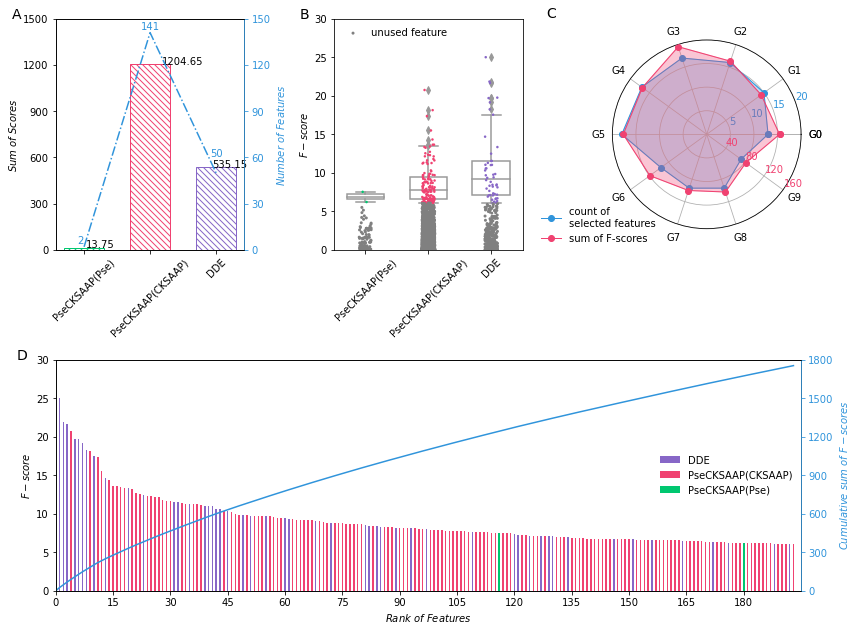

In [11]:
def feature_rank():
    x = range(3)
    fig = plt.figure(4, figsize=(12, 9))
    ax1 = fig.add_subplot(231)
    ax1.bar(
        x,
        sum_of_score_of_methods[:3],
        width=0.6,
        hatch='\\\\\\\\',
        color='white',
        edgecolor=colors[:3],
    )
    ax1.set_yticks([i for i in range(0, 1501, 300)])
    ax1.set_ylabel(r'$\it{Sum}$ $\it{of}$ $\it{Scores}$')
    ax1.set_xticks(x)
    ax1.set_xticklabels(
        ['PseCKSAAP(Pse)', 'PseCKSAAP(CKSAAP)', 'DDE'], rotation=45
    )
    ax1.text(
        0 + 0.25,
        F_PD_Pse.sum() + 50,
        '%.2f' % F_PD_Pse.sum(),
        ha='center',
        va='top',
        fontsize=10,
        color='k',
    )
    ax1.text(
        1 + 0.5,
        F_PD_CKSAAP.sum() + 50,
        '%.2f' % F_PD_CKSAAP.sum(),
        ha='center',
        va='top',
        fontsize=10,
        color='k',
    )
    ax1.text(
        2 + 0.2,
        F_PD_DDE.sum() + 50,
        '%.2f' % F_PD_DDE.sum(),
        ha='center',
        va='top',
        fontsize=10,
        color='k',
    )
    ax1.legend(frameon=False)
    ax1.text(-1.1, 1500, 'A', fontsize=14)

    ax1_2 = ax1.twinx()
    ax1_2.plot(
        ['PseCKSAAP(Pse)', 'PseCKSAAP(CKSAAP)', 'DDE'],
        np.array(count_of_feature_of_methods),
        '-.',
        color=colors[3],
    )
    ax1_2.set_yticks([i for i in range(0, 151, 30)])
    ax1_2.set_ylabel(
        r'$\it{Number}$ $\it{of}$ $\it{Features}$', color=colors[3]
    )
    ax1_2.spines['right'].set_color(colors[3])
    ax1_2.tick_params(color=colors[3], labelcolor=colors[3])
    ax1_2.text(
        0 - 0.05,
        F_PD_Pse.count() + 7,
        '%d' % F_PD_Pse.count(),
        ha='center',
        va='top',
        fontsize=10,
        color=colors[3],
    )
    ax1_2.text(
        1,
        F_PD_CKSAAP.count() + 7,
        '%d' % F_PD_CKSAAP.count(),
        ha='center',
        va='top',
        fontsize=10,
        color=colors[3],
    )
    ax1_2.text(
        2,
        F_PD_DDE.count() + 16,
        '%d' % F_PD_DDE.count(),
        ha='center',
        va='top',
        fontsize=10,
        color=colors[3],
    )
    ax1_2.set_ylim(0, 150)

    # B
    ax2 = fig.add_subplot(232)
    ax2 = sns.stripplot(
        data=[F_PD_Pse, F_PD_CKSAAP, F_PD_DDE],
        jitter=0.1,
        palette=colors[:3],
        marker='.',
        size=5,
    )
    ax2 = sns.stripplot(
        data=[
            F_Pse.drop(F_PD_Pse.index),
            F_CKSAAP.drop(F_PD_CKSAAP.index),
            F_DDE.drop(F_PD_DDE.index),
        ],
        jitter=0.1,
        marker='.',
        palette=['grey'] * 3,
        size=6,
        label='unused feature',
    )
    handles, labels = ax2.get_legend_handles_labels()
    legends = dict(zip(labels, handles))
    ax2.legend(
        legends.values(), legends.keys(), loc='upper left', frameon=False
    )
    ax2 = sns.boxplot(
        data=[F_PD_Pse, F_PD_CKSAAP, F_PD_DDE],
        palette=['w'] * 3,
        width=0.6,
        linewidth=1.5,
    )
    ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax2.set_ylim(0, 30)
    ax2.set_ylabel(r'$\it{F-score}$')
    ax2.text(-1.05, 30, 'B', fontsize=14)

    # C
    values = [
        F_PD_CKSAAP[
            F_PD_CKSAAP.index.isin(
                re.findall(r'\w+\.' + str(i), str(F_PD_CKSAAP.index.to_list()))
            )
        ].count()
        for i in range(10)
    ]
    gap_scores = [
        F_PD_CKSAAP[
            F_PD_CKSAAP.index.isin(
                re.findall(r'\w+\.' + str(i), str(F_PD_CKSAAP.index.to_list()))
            )
        ].sum()
        for i in range(10)
    ]
    angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False)
    values = np.append(values, values[0])
    gap_scores = np.append(gap_scores, gap_scores[0])
    angles = np.append(angles, angles[0])
    gaps = [''] + ['G' + str(i) for i in range(1, 10)] + ['G0']

    ax3 = fig.add_subplot(233, polar=True, label='ax3')
    ax3.plot(angles, values, 'o-', c=colors[-1], linewidth=1)
    ax3.fill(angles, values, c=colors[-1], alpha=0.3)
    ax3.set_thetagrids(angles * 180 / np.pi, gaps)
    ax3.set_rgrids(
        range(5, 21, 5),
        angle=20,
        labels=[str(i) for i in range(5, 21, 5)],
        color=colors[-1],
    )
    ax3.set_ylim(0, 20)
    ax3.grid(True)
    ax3.legend(
        ['count of \nselected features'], frameon=False, loc=(-0.4, -0.02)
    )
    ax3.text(0.8 * np.pi, 42, 'C', fontsize=14)  # 2.1 * ylim

    # a compromizing way, inspired by the ref link:
    # https://stackoverflow.com/questions/24659005/ \
    # radar-chart-with-multiple-scales-on-multiple-axes
    ax3_2 = fig.add_subplot(233, polar=True, label='ax3_2')
    ax3_2.plot(angles, gap_scores, 'o-', c=colors[1], linewidth=1)
    ax3_2.fill(angles, gap_scores, c=colors[1], alpha=0.3)
    ax3_2.patch.set_visible(False)
    ax3_2.grid(False)
    ax3_2.xaxis.set_visible(False)

    ax3_2.set_rgrids(
        range(40, 161, 40),
        angle=-35,
        labels=[str(i) for i in range(40, 161, 40)],
        color=colors[1],
    )
    ax3_2.spines["polar"].set_visible(False)
    ax3_2.set_ylim(0, 160)
    ax3_2.legend(['sum of F-scores'], frameon=False, loc=(-0.4, -0.1))

    # D
    ax4 = fig.add_subplot(212)
    label = 'F-score'
    color = 'k'
    values = F_PD.values.flatten()
    for i in number_of_features:
        if F_PD.iloc[i - 1, :].name in F_PD_CKSAAP.index:
            label = 'PseCKSAAP(CKSAAP)'
            color = colors[1]
        elif F_PD.iloc[i - 1, :].name in F_PD_DDE.index:
            label = 'DDE'
            color = colors[2]
        else:
            label = 'PseCKSAAP(Pse)'
            color = colors[0]
        ax4.bar(
            i, values[i - 1], width=0.4, label=label, color=color,
        )
    handles, labels = ax4.get_legend_handles_labels()
    legends = dict(zip(labels, handles))
    ax4.legend(legends.values(), legends.keys(), loc='right', frameon=False)
    ax4.set_yticks([x for x in range(0, 31, 5)])
    ax4.set_ylabel(r'$\it{F-score}$')
    ax4.set_xticks([x for x in range(0, best_d + 1, 15)])
    ax4.set_xlabel(r'$\it{Rank}$ $\it{of}$ $\it{Features}$')
    ax4.set(xlim=[0, best_d + (15 - best_d % 15)], ylim=[0, 30])
    ax4.text(-10.2, 30, 'D', fontsize=14)  # -0.06 * xlim

    ax4_2 = ax4.twinx()
    ax4_2.plot(
        range(best_d + 1),
        np.r_[0, F_PD.cumsum().values.flatten()],
        linestyle='-',
        color=colors[3],
    )
    ax4_2.set_yticks([x for x in range(0, 1801, 300)])
    ax4_2.set_ylim(0, 1800)
    ax4_2.set_ylabel(
        r'$\it{Cumulative}$ $\it{sum}$ $\it{of}$ $\it{F-scores}$',
        color=colors[3],
    )
    ax4_2.spines['right'].set_color(colors[3])
    ax4_2.tick_params(color=colors[3], labelcolor=colors[3])
    fig.tight_layout()
    plt.savefig(os.path.join(data_path, 'feature_rank.jpg'), dpi=600)


feature_rank()

/tmp/ipykernel_1076/721983331.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_1076/721983331.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_sec.tight_layout(rect=[0, 0, 0.9, 1])


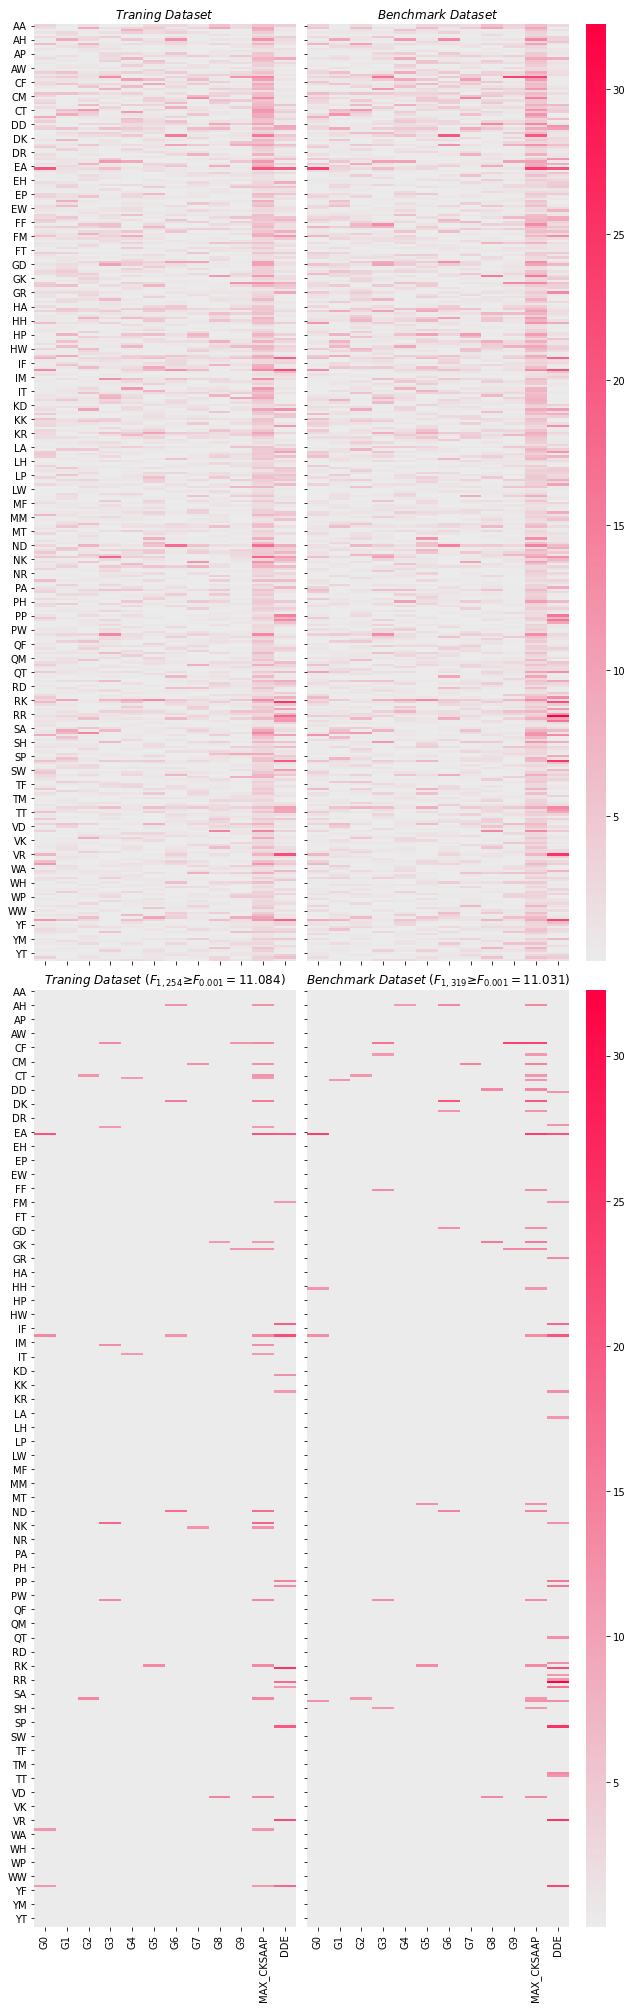

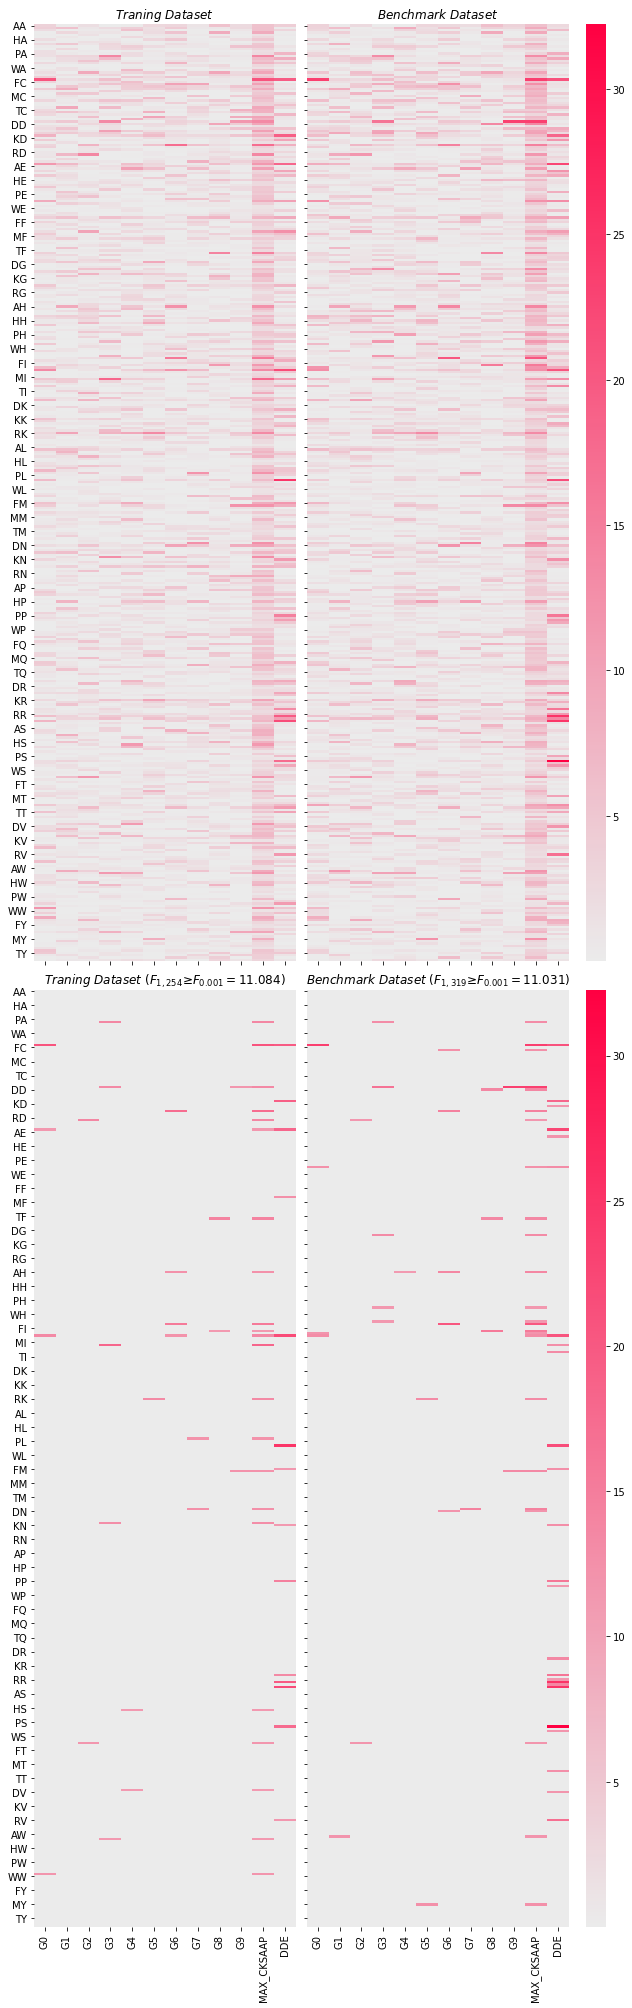

In [12]:
def cksaap_dde():
    fscore_heatmap = np.zeros((400, 0))
    for g in range(10):
        fscore_heatmap = np.c_[
            fscore_heatmap,
            F_CKSAAP[
                F_CKSAAP.index.isin(
                    re.findall(r'\w+.' + str(g), str(F_CKSAAP.index.to_list()))
                )
            ]
            .sort_index()
            .values,
        ]
    fscore_heatmap = np.c_[
        fscore_heatmap, fscore_heatmap.max(axis=1), F_DDE.sort_index().values
    ]
    fscore_heatmap = pd.DataFrame(
        fscore_heatmap,
        index=DPs,
        columns=['G' + str(i) for i in range(10)] + ['MAX_CKSAAP', 'DDE'],
    )
    feature_all = pd.read_csv(
        os.path.join(feature_path, 'feature_all.csv'), index_col=0
    )
    pos_num = 114
    neg_num = 207
    label = np.array([1] * pos_num + [0] * neg_num)
    F_SCORE, P_VALUE = f_classif(feature_all, label)
    F_SCORE = pd.Series(F_SCORE, index=feature_all.columns).sort_values(
        ascending=False
    )
    P_VALUE = pd.Series(P_VALUE, index=feature_all.columns).sort_values(
        ascending=True
    )
    pd.DataFrame(F_SCORE).to_csv(
        os.path.join(data_path, 'f_score_benchmark.csv'), header=False
    )
    pd.DataFrame(P_VALUE).to_csv(
        os.path.join(data_path, 'p_value_benchmark.csv'), header=False
    )
    F_CKSAAP_total = F_SCORE[
        F_SCORE.index.isin(re.findall(re_CKSAAP, str(F_SCORE.index.to_list())))
    ]
    F_DDE_total = F_SCORE[
        F_SCORE.index.isin(re.findall(re_DDE, str(F_SCORE.index.to_list())))
    ]

    FSCORE_heatmap = np.zeros((400, 0))
    for g in range(10):
        FSCORE_heatmap = np.c_[
            FSCORE_heatmap,
            F_CKSAAP_total[
                F_CKSAAP_total.index.isin(
                    re.findall(
                        r'\w+.' + str(g), str(F_CKSAAP_total.index.to_list())
                    )
                )
            ]
            .sort_index()
            .values,
        ]
    FSCORE_heatmap = np.c_[
        FSCORE_heatmap,
        FSCORE_heatmap.max(axis=1),
        F_DDE_total.sort_index().values,
    ]
    FSCORE_heatmap = pd.DataFrame(
        FSCORE_heatmap,
        index=DPs,
        columns=['G' + str(i) for i in range(10)] + ['MAX_CKSAAP', 'DDE'],
    )
    fig, axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 28))
    cbar_axes = [
        fig.add_axes([0.91, 0.521, 0.03, 0.465]),
        fig.add_axes([0.91, 0.042, 0.03, 0.4645]),
    ]
    # from scipy.stats import f
    # f(2-1, 256-2).ppf(1-0.001), f(1, 254).ppf(1-0.01),f(1, 254).ppf(1-0.05)
    # (11.083846195746949, 6.735703930741392, 3.878329734167353)
    # f(2-1, 321-2).ppf(1-0.001), f(1, 319).ppf(1-0.01),f(1, 319).ppf(1-0.05)
    # (11.030940082481472, 6.714985325381564, 3.870774457589267)
    hmap = dict(
        zip(
            range(4),
            [
                fscore_heatmap,
                FSCORE_heatmap,
                fscore_heatmap[fscore_heatmap >= 11.084].fillna(0),
                FSCORE_heatmap[FSCORE_heatmap >= 11.031].fillna(0),
            ],
        )
    )
    vmin = min(fscore_heatmap.min().min(), FSCORE_heatmap.min().min())
    vmax = max(fscore_heatmap.max().max(), FSCORE_heatmap.max().max())
    titles = dict(
        zip(
            range(4),
            [
                r'$\it{Traning}$ $\it{Dataset}$',
                r'$\it{Benchmark}$ $\it{Dataset}$',
                r'$\it{Traning}$ $\it{Dataset}$ '
                + r'$(\it{F}_{1,254} ≥ \it{F}_{0.001} = 11.084)$',
                r'$\it{Benchmark}$ $\it{Dataset}$ '
                + r'$(\it{F}_{1,319} ≥ \it{F}_{0.001} = 11.031)$',
            ],
        )
    )
    # cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)
    cmap = clr.LinearSegmentedColormap.from_list(
        'grey2red', [(0, '#EBEBEB'), (1, '#FF0042')]
    )
    for i, ax in enumerate(axn.flat):
        sns.heatmap(
            hmap[i],
            ax=ax,
            cbar=([1, 0] * 2)[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar_ax=cbar_axes[i // 2] if i % 2 == 0 else None,
        )
        ax.set_title(titles[i])

    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(data_path, 'cksaap_dde_heatmap.jpg'), dpi=600)

    fig_sec, axn_sec = plt.subplots(
        2, 2, sharex=True, sharey=True, figsize=(9, 28)
    )
    cbar_axes = [
        fig_sec.add_axes([0.91, 0.521, 0.03, 0.465]),
        fig_sec.add_axes([0.91, 0.042, 0.03, 0.4645]),
    ]
    DPs_sec = [aa2 + aa1 for aa1 in AA for aa2 in AA]
    fscore_heatmap = fscore_heatmap.loc[DPs_sec, :]
    FSCORE_heatmap = FSCORE_heatmap.loc[DPs_sec, :]
    hmap = dict(
        zip(
            range(4),
            [
                fscore_heatmap,
                FSCORE_heatmap,
                fscore_heatmap[fscore_heatmap >= 11.084].fillna(0),
                FSCORE_heatmap[FSCORE_heatmap >= 11.031].fillna(0),
            ],
        )
    )
    for i, ax in enumerate(axn_sec.flat):
        sns.heatmap(
            hmap[i],
            ax=ax,
            cbar=([1, 0] * 2)[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar_ax=cbar_axes[i // 2] if i % 2 == 0 else None,
        )
        ax.set_title(titles[i])

    fig_sec.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(os.path.join(data_path, 'cksaap_dde_heatmap_sec.jpg'), dpi=600)


cksaap_dde()

total counts of dipeptides used in cksaap and dde

In [13]:
# some data analysis
dde_cksaap = F_PD_DDE.index.to_list() + F_PD_CKSAAP.index.to_list()
dipeps = [*map(lambda x: x.split('.')[0], dde_cksaap)]
set_ = set(dipeps)
dipeps_counts = pd.Series(
    {item: dipeps.count(item) for item in set_}
).sort_values(ascending=False)
# list parts of them
dipeps_counts[dipeps_counts > 2]

II    5
YD    5
RK    4
YC    3
ID    3
HP    3
TR    3
DF    3
CE    3
HV    3
ND    3
RT    3
dtype: int64

In [14]:
dipeps_counts[dipeps_counts > 1]

II    5
YD    5
RK    4
YC    3
ID    3
HP    3
TR    3
DF    3
CE    3
HV    3
ND    3
RT    3
CD    2
EC    2
IN    2
GM    2
HG    2
AC    2
SE    2
AR    2
SD    2
RA    2
IH    2
SC    2
FM    2
RL    2
CT    2
IY    2
IW    2
DN    2
VR    2
GC    2
DW    2
NN    2
GN    2
KF    2
AH    2
NV    2
NI    2
AK    2
dtype: int64

In [15]:
temp = ''.join(dipeps)
peps_counts = pd.Series({item: temp.count(item) for item in AA}).sort_values(
    ascending=False
)
peps_counts

C    36
I    35
D    33
R    30
N    26
S    21
H    19
A    17
V    17
T    16
G    16
K    16
Y    15
F    15
E    14
W    13
P    12
L    11
Q    10
M    10
dtype: int64